                      Obstacles_Removed  Obstacles_Removed_Percentage  \
Explanation Planner                                                     
Anchors     A*                    4.371                         0.291   
            BFS                   4.371                         0.291   
            Dijkstra              4.371                         0.291   
            Theta*                2.931                         0.195   
LIME        A*                    1.009                         0.067   
            BFS                   1.009                         0.067   
            Dijkstra              1.009                         0.067   
            Theta*                1.000                         0.067   
SHAP        A*                    1.046                         0.070   
            BFS                   1.046                         0.070   
            Dijkstra              1.046                         0.070   
            Theta*                1.016            

C:\Users\Vahidin\AppData\Local\Temp\ipykernel_29764\2256919204.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Explanation', y=metric, data=df, palette=explanation_colors)
C:\Users\Vahidin\AppData\Local\Temp\ipykernel_29764\2256919204.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Explanation', y=metric, data=df, palette=explanation_colors)
C:\Users\Vahidin\AppData\Local\Temp\ipykernel_29764\2256919204.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Explanation', y=metric, data=df, palette=explanation_colors)
C:\User

Analysis complete. All figures saved to: ./figures/when_is_plan_possible


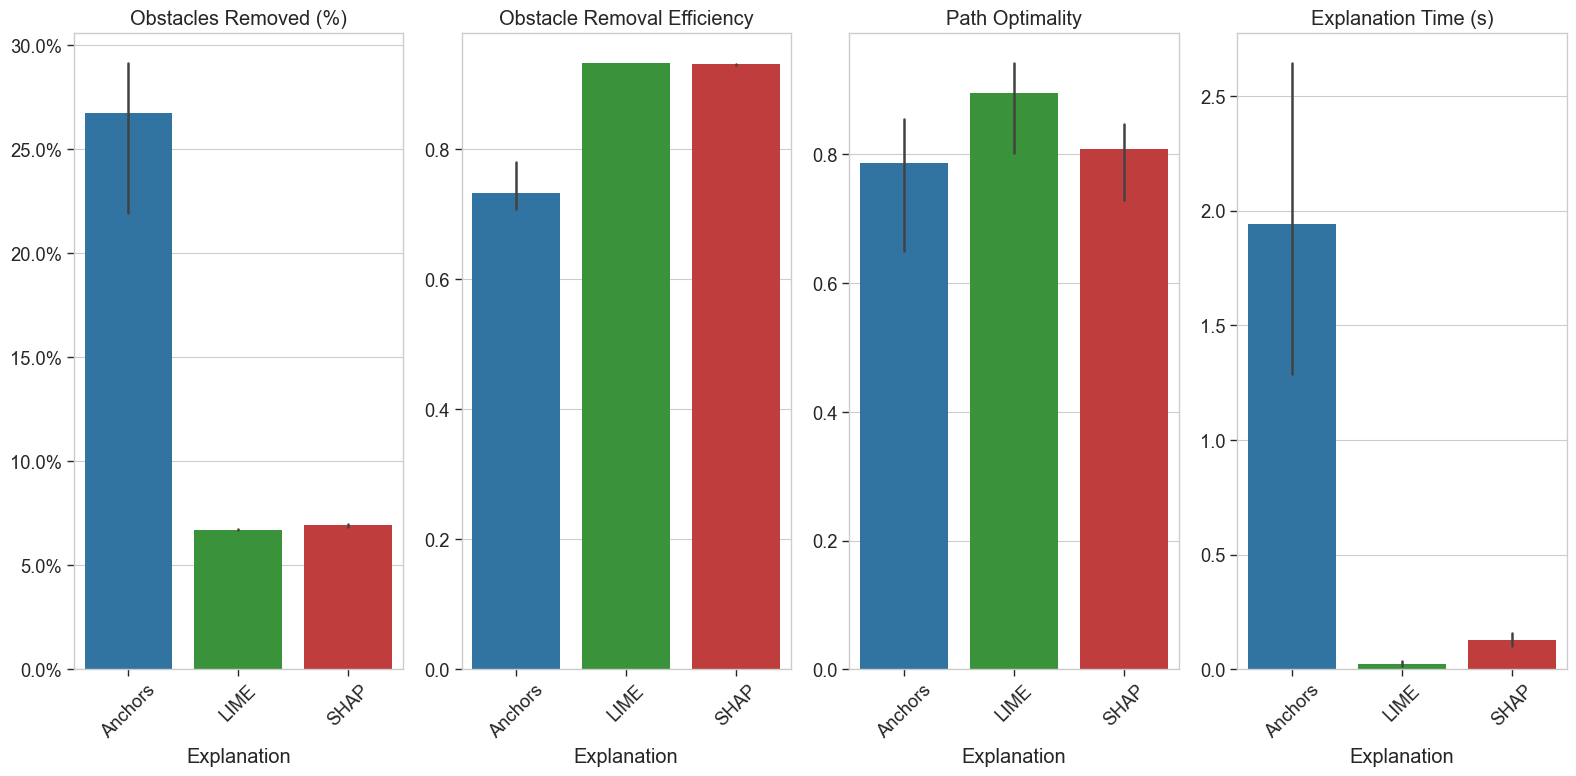

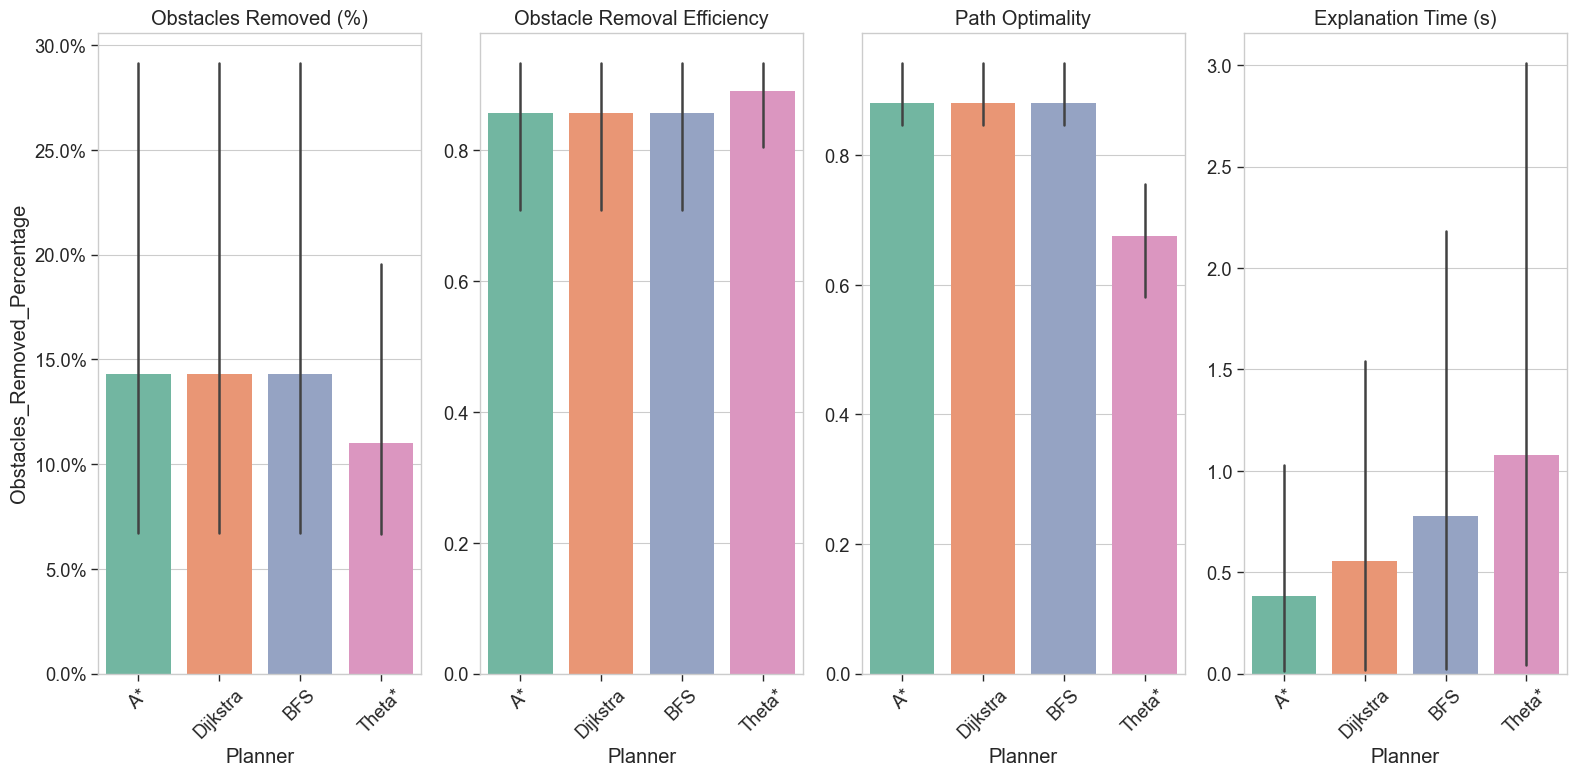

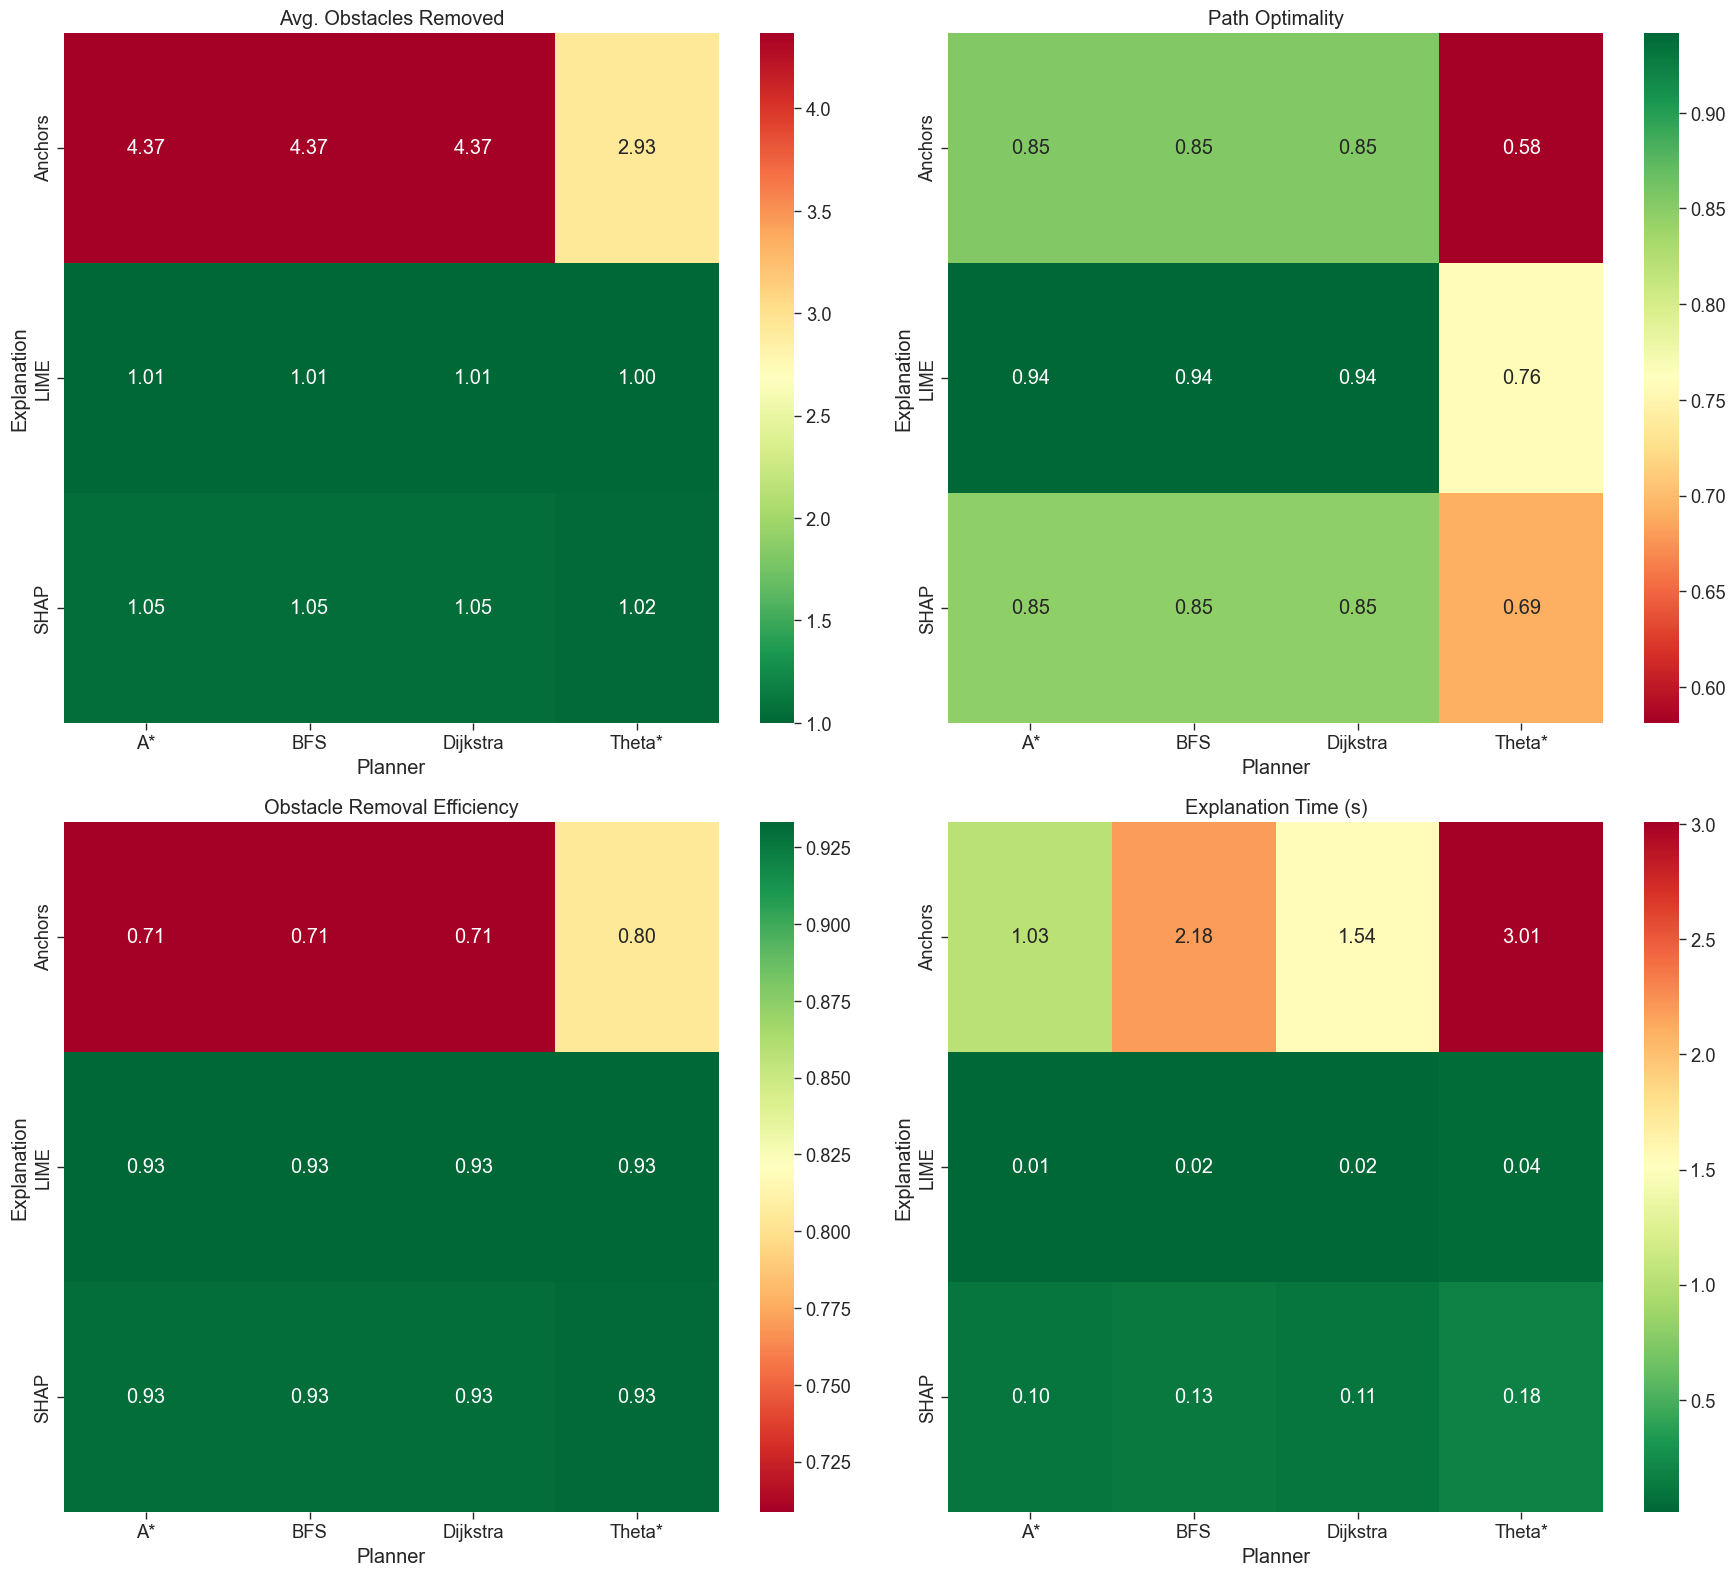

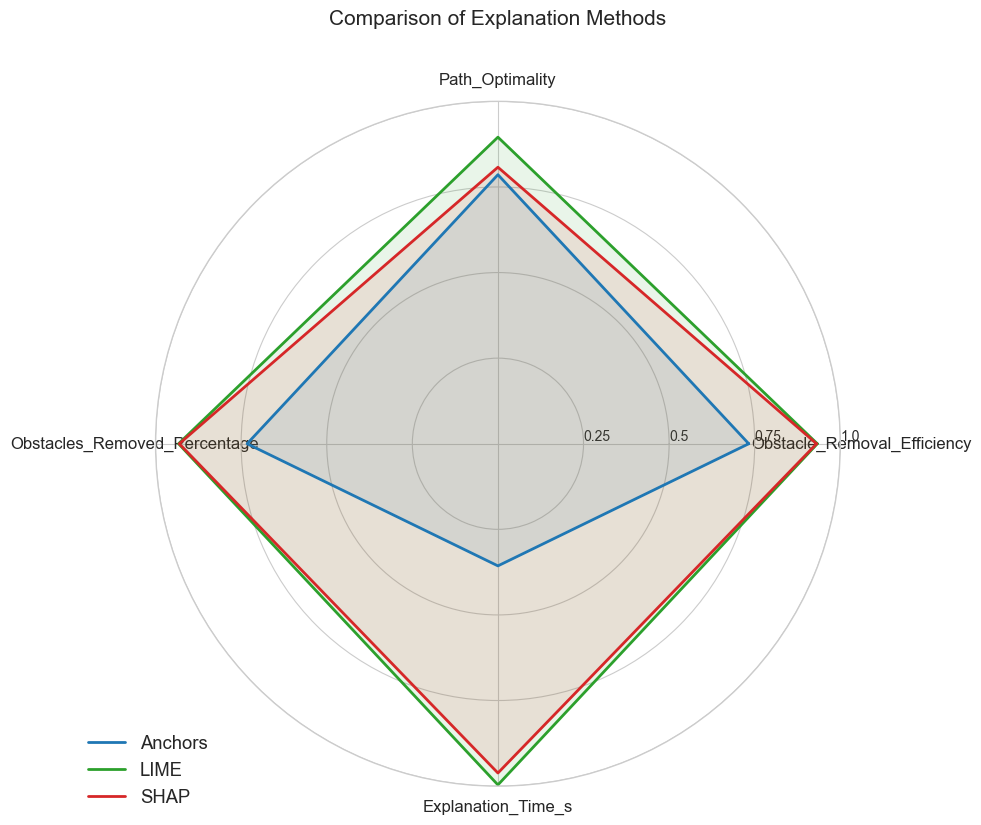

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# Define consistent colors for each explanation method (same as why_did_you_fail_analysis)
explanation_colors = {'Anchors': '#1f77b4', 'LIME': '#2ca02c', 'SHAP': '#d62728'}
colors = [explanation_colors[exp] for exp in ['Anchors', 'LIME', 'SHAP']]

# Load the data
df = pd.read_csv('./when_is_plan_possible_results.csv')

# Display basic statistics
print(df.groupby(['Explanation', 'Planner']).mean().round(3))

# Create a figure directory if it doesn't exist
import os
figures_dir = './figures/when_is_plan_possible'
os.makedirs(figures_dir, exist_ok=True)

# ======= Figure 1: Explanation Method Comparison =======
plt.figure(figsize=(16, 8))
metrics = ['Obstacles_Removed_Percentage', 'Obstacle_Removal_Efficiency', 
           'Path_Optimality', 'Explanation_Time_s']
titles = ['Obstacles Removed (%)', 'Obstacle Removal Efficiency', 
          'Path Optimality', 'Explanation Time (s)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    plt.subplot(1, 4, i+1)
    # Use consistent colors for explanation methods
    sns.barplot(x='Explanation', y=metric, data=df, palette=explanation_colors)
    plt.title(title)
    plt.ylabel('')
    if metric == 'Obstacles_Removed_Percentage':
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if i > 0:
        plt.ylabel('')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f"{figures_dir}/explanation_comparison.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{figures_dir}/explanation_comparison.png", bbox_inches='tight', dpi=300)

# ======= Figure 2: Planner Comparison =======
plt.figure(figsize=(16, 8))
planner_palette = sns.color_palette("Set2", n_colors=len(df['Planner'].unique()))

for i, (metric, title) in enumerate(zip(metrics, titles)):
    plt.subplot(1, 4, i+1)
    sns.barplot(x='Planner', y=metric, data=df, palette=planner_palette)
    plt.title(title)
    if metric == 'Obstacles_Removed_Percentage':
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if i > 0:
        plt.ylabel('')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f"{figures_dir}/planner_comparison.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{figures_dir}/planner_comparison.png", bbox_inches='tight', dpi=300)

# ======= Figure 3: Combined Heatmap Analysis =======
# Create pivot tables for key metrics
fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(2, 2, figure=fig)

metrics = ['Obstacles_Removed', 'Path_Optimality', 
           'Obstacle_Removal_Efficiency', 'Explanation_Time_s']
titles = ['Avg. Obstacles Removed', 'Path Optimality', 
          'Obstacle Removal Efficiency', 'Explanation Time (s)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = fig.add_subplot(gs[i//2, i%2])
    pivot = pd.pivot_table(df, values=metric, 
                         index='Explanation', columns='Planner', 
                         aggfunc='mean')
    
    # Custom colormap: green is good (high for efficiency, low for others)
    if metric in ['Obstacle_Removal_Efficiency', 'Path_Optimality']:
        cmap = 'RdYlGn'
    else:  # Obstacles_Removed, Explanation_Time_s
        cmap = 'RdYlGn_r'
        
    sns.heatmap(pivot, annot=True, cmap=cmap, fmt='.2f', ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.savefig(f"{figures_dir}/combined_heatmap.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{figures_dir}/combined_heatmap.png", bbox_inches='tight', dpi=300)

# ======= Figure 4: Multi-metric Comparison =======
# Radar chart comparing explanation methods
def radar_chart(df, group_col, metrics):
    # Compute the means for each group
    means = df.groupby(group_col)[metrics].mean()
    
    # Number of variables
    N = len(metrics)
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], metrics, size=12)
    
    # Draw the y-axis labels (0-100%)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1], ["0.25", "0.5", "0.75", "1.0"], size=10)
    plt.ylim(0, 1)
    
    # Plot each group with consistent colors
    for i, (name, values) in enumerate(means.iterrows()):
        values_norm = values.copy()
        
        # Normalize metrics to 0-1 range for radar chart
        for m in metrics:
            if m == 'Obstacles_Removed_Percentage':
                # Lower is better for obstacles removed
                values_norm[m] = 1 - values[m]
            elif m == 'Explanation_Time_s':
                # Normalize time to 0-1 where 0 is the max time and 1 is the min time
                values_norm[m] = 1 - (values[m] - df[m].min()) / (df[m].max() - df[m].min())
        
        values_list = values_norm.values.flatten().tolist()
        values_list += values_list[:1]  # Close the loop
        
        # Use consistent color for each explanation method
        color = explanation_colors[name] if name in explanation_colors else f'C{i}'
        ax.plot(angles, values_list, linewidth=2, linestyle='solid', label=name, color=color)
        ax.fill(angles, values_list, color=color, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    return fig

# Normalize metrics for radar chart
radar_metrics = ['Obstacle_Removal_Efficiency', 'Path_Optimality', 
                'Obstacles_Removed_Percentage', 'Explanation_Time_s']

# Create radar charts
radar_fig = radar_chart(df, 'Explanation', radar_metrics)
plt.title('Comparison of Explanation Methods', size=15, y=1.1)
plt.tight_layout()
plt.savefig(f"{figures_dir}/explanation_radar.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{figures_dir}/explanation_radar.png", bbox_inches='tight', dpi=300)

# # ======= Figure 5: Tradeoff Analysis =======
# plt.figure(figsize=(12, 10))

# # Create a mapping for planner markers
# planners = df['Planner'].unique()
# markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'X'][:len(planners)]
# planner_markers = {planner: marker for planner, marker in zip(planners, markers)}

# # Plot each explanation method with its consistent color
# for exp in df['Explanation'].unique():
#     for planner in planners:
#         subset = df[(df['Explanation'] == exp) & (df['Planner'] == planner)]
#         plt.scatter(subset['Obstacles_Removed_Percentage'], subset['Path_Optimality'], 
#                    color=explanation_colors[exp], marker=planner_markers[planner], 
#                    s=200, label=f"{exp} - {planner}" if planner == planners[0] else None)

# plt.xlabel('Obstacles Removed (%)')
# plt.ylabel('Path Optimality')
# plt.title('Tradeoff: Minimizing Obstacle Removal vs Path Optimality')
# plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# plt.grid(True, linestyle='--', alpha=0.7)

# # Create two legends - one for explanation methods and one for planners
# from matplotlib.lines import Line2D
# explanation_legend_elements = [Line2D([0], [0], marker='o', color='w', 
#                                      markerfacecolor=color, markersize=10, label=exp)
#                               for exp, color in explanation_colors.items()]
# planner_legend_elements = [Line2D([0], [0], marker=marker, color='gray', 
#                                  linestyle='None', markersize=10, label=planner)
#                           for planner, marker in planner_markers.items()]

# first_legend = plt.legend(handles=explanation_legend_elements, loc='upper left', 
#                          bbox_to_anchor=(1.05, 1), title='Explanation')
# plt.gca().add_artist(first_legend)
# plt.legend(handles=planner_legend_elements, loc='upper left', 
#           bbox_to_anchor=(1.05, 0.6), title='Planner')

# plt.tight_layout()
# plt.savefig(f"{figures_dir}/tradeoff_analysis.pdf", bbox_inches='tight', dpi=300)
# plt.savefig(f"{figures_dir}/tradeoff_analysis.png", bbox_inches='tight', dpi=300)

# # ======= Figure 6: Statistical Analysis =======
# # Perform ANOVA tests to determine statistical significance
# explanations = df['Explanation'].unique()
# planners = df['Planner'].unique()

# plt.figure(figsize=(15, 10))
# gs = gridspec.GridSpec(2, 2)

# for i, metric in enumerate(['Obstacles_Removed_Percentage', 'Path_Optimality', 
#                            'Obstacle_Removal_Efficiency', 'Explanation_Time_s']):
#     ax = plt.subplot(gs[i//2, i%2])
    
#     # Box plot with consistent colors
#     sns.boxplot(x='Explanation', y=metric, data=df, ax=ax, palette=explanation_colors)
    
#     # Perform statistical test
#     f_stat, p_val = stats.f_oneway(
#         *[df[df['Explanation'] == exp][metric].values for exp in explanations]
#     )
    
#     # Add p-value annotation
#     ax.text(0.5, 0.95, f'ANOVA: p={p_val:.4f}', 
#             horizontalalignment='center', verticalalignment='center', 
#             transform=ax.transAxes, fontsize=12,
#             bbox=dict(facecolor='white', alpha=0.8))
    
#     ax.set_title(f'{metric.replace("_", " ")}')
#     if metric == 'Obstacles_Removed_Percentage':
#         ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# plt.tight_layout()
# plt.savefig(f"{figures_dir}/statistical_analysis.pdf", bbox_inches='tight', dpi=300)
# plt.savefig(f"{figures_dir}/statistical_analysis.png", bbox_inches='tight', dpi=300)

# # ======= Figure 7: Combined Visualization =======
# # Create a new figure showing the main metrics in one comprehensive visualization
# fig, ax = plt.subplots(figsize=(14, 10))

# # Create a bubble chart where:
# # - X-axis: Obstacle removal efficiency
# # - Y-axis: Path optimality
# # - Bubble size: Inverse of explanation time (bigger = faster)
# # - Color: Explanation method
# # - Shape: Planner

# # Calculate size based on inverse of explanation time (normalized)
# max_time = df['Explanation_Time_s'].max()
# sizes = 1000 * (1 - df['Explanation_Time_s'] / max_time) + 100  # +100 to ensure minimum size

# # Plot each point
# for exp in df['Explanation'].unique():
#     for planner in planners:
#         subset = df[(df['Explanation'] == exp) & (df['Planner'] == planner)]
#         if not subset.empty:
#             plt.scatter(
#                 subset['Obstacle_Removal_Efficiency'], 
#                 subset['Path_Optimality'],
#                 s=sizes[subset.index], 
#                 color=explanation_colors[exp],
#                 marker=planner_markers[planner],
#                 alpha=0.7,
#                 edgecolors='black',
#                 linewidth=1,
#                 label=f"{exp} - {planner}"
#             )

# plt.grid(True, linestyle='--', alpha=0.5)
# plt.xlabel('Obstacle Removal Efficiency (higher is better)')
# plt.ylabel('Path Optimality (higher is better)')
# plt.title('Comprehensive Performance Visualization', fontsize=16)

# # Create custom legends
# exp_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
#                     markersize=15, label=exp) for exp, color in explanation_colors.items()]
# plan_legend = [Line2D([0], [0], marker=marker, color='black', 
#                      markersize=10, label=planner) for planner, marker in planner_markers.items()]
# size_legend = [Line2D([0], [0], marker='o', color='gray', markersize=size/100, 
#                      label=f"{time:.2f}s") 
#               for size, time in zip([100, 500, 900], 
#                                    [max_time, max_time/2, 0.01])]

# first_legend = plt.legend(handles=exp_legend, title="Explanation Method", 
#                          loc='upper left', bbox_to_anchor=(1.05, 1))
# plt.gca().add_artist(first_legend)
# second_legend = plt.legend(handles=plan_legend, title="Planner", 
#                           loc='upper left', bbox_to_anchor=(1.05, 0.7))
# plt.gca().add_artist(second_legend)
# plt.legend(handles=size_legend, title="Explanation Time", 
#           loc='upper left', bbox_to_anchor=(1.05, 0.4))

# plt.tight_layout()
# plt.savefig(f"{figures_dir}/comprehensive_visualization.pdf", bbox_inches='tight', dpi=300)
# plt.savefig(f"{figures_dir}/comprehensive_visualization.png", bbox_inches='tight', dpi=300)

# ======= Table: Summary Statistics =======
# Create a summary table for the paper
summary = df.groupby(['Explanation', 'Planner']).agg({
    'Obstacles_Removed': 'mean',
    'Obstacles_Removed_Percentage': 'mean',
    'Obstacle_Removal_Efficiency': 'mean',
    'Path_Optimality': 'mean',
    'Explanation_Time_s': 'mean'
}).round(3)

# Save the summary table
summary.to_csv(f"{figures_dir}/summary_table.csv")

# Print completion message
print("Analysis complete. All figures saved to:", figures_dir)